In [1]:
!pip install tensorflow-model-optimization


In [2]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pathlib
import tensorflow_model_optimization as tfmot

In [3]:
!pip install tensorflow_model_optimization

In [5]:
from tensorflow_model_optimization.python.core.keras.compat import keras

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [6]:
# Requirements
requirements1 = keras.callbacks.ModelCheckpoint(
            "/content/main/PQT_normal_model.keras",
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            save_freq="epoch")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42310 (165.27 KB)
Trainable params: 42310 (165.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
235/235 [==============================] - 8s 8ms/step - loss: 4.9152 - accuracy: 0.7376 - val_loss: 0.9889 - val_accuracy: 0.8181
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.7383 - accuracy: 0.8449 - val_loss: 0.6154 - val_accuracy: 0.862

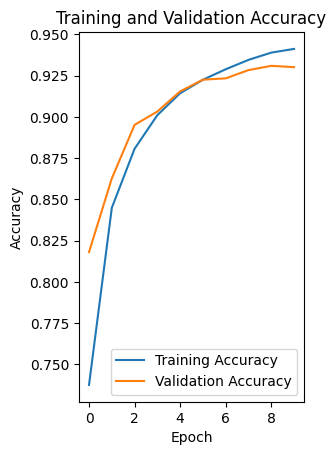

In [7]:
# Normal Model
model = keras.Sequential()
model.add(keras.layers.Input(shape = (784,)))
model.add(keras.layers.Dense(50, activation = "relu"))
model.add(keras.layers.Dense(50, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))
# Model summary
model.summary()
# Compiling the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
# Fitting the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 256, validation_data = (X_test, y_test), callbacks = [requirements1])
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#PQT- Compression

In [8]:
# loading the normal model
start1 = time.time()
model1 = keras.models.load_model("/content/main/PQT_normal_model.keras")
end1 = time.time()
total1 = end1 - start1
print(f"Total time taken to load normal model is {total1}")
#model1.summary()

# convert the model
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model1)
converter.optimizations = [tensorflow.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# save the model
with open(("/content/main/PQT_compressed_model.tflite"), mode = 'wb') as file:
    file.write(tflite_quant_model)

# Loading tflite model
start2 = time.time()
compressed_model = tensorflow.lite.Interpreter(model_path = r"/content/main/PQT_compressed_model.tflite")
compressed_model.allocate_tensors()
end2 = time.time()
total2 = end2 - start2
print(f"Total time taken to load quantized model is {total2}")

Total time taken to load normal model is 0.08692741394042969
Total time taken to load quantized model is 0.030555009841918945


# PQT- Compression + Quantization

In [9]:
# load the model
model2 = keras.models.load_model("/content/main/PQT_normal_model.keras")
#model2.summary()

# Quantize the loaded model
quantize_model = tfmot.quantization.keras.quantize_model
quantized_model = quantize_model(model2)

# convert the model
converter = tensorflow.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tensorflow.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# save the model
with open(("/content/main/PQT_compressed_quantize_model.tflite"), mode = 'wb') as file:
    file.write(tflite_quant_model)

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Epoch 1/10
235/235 [==============================] - 4s 5ms/step - loss: 0.3840 - accuracy: 0.8998 - val_loss: 0.3020 - val_accuracy: 0.9247
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2770 - accuracy: 0.9312 - val_loss: 0.2987 - val_accuracy: 0.9320
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2332 - accuracy: 0.9407 - val_loss: 0.2572 - val_accuracy: 0.9374
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.2067 - accuracy: 0.9457 - val_loss: 0.2540 - val_accuracy: 0.9436
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1790 - accuracy: 0.9505 - val_loss: 0.2503 - val_accuracy: 0.9441
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.9531 - val_loss: 0.2390 - val_accuracy: 0.9453
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1573 - accuracy: 0.9556 - val_loss: 0.2318 - val_accuracy: 0.9485
Epoch 

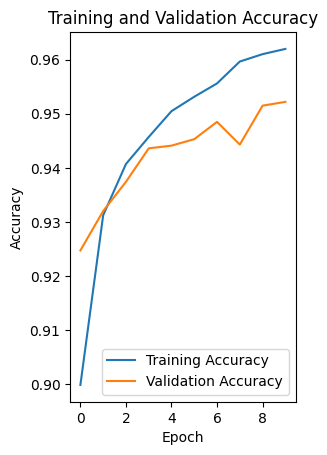

In [10]:

quantized_model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
# Fitting the model
history_3 = quantized_model.fit(X_train, y_train, epochs = 10, batch_size = 256, validation_data = (X_test, y_test), callbacks = [requirements1])
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Quantization Aware Training

* Normal Approach: Create a model --> compile the model --> fit the model
 Graph( TA vs VA) and (TL vs VL)
* Quantization Aware Approach: Create a model --> quantize the model --> compile the model --> fit the model
 Graph( TA vs VA) and (TL vs VL)

* Normal Approach: Create a model --> compile the model --> fit the model
Graph( TA vs VA) and (TL vs VL)

In [11]:
# Requirements
requirements2 = keras.callbacks.ModelCheckpoint(
            "/content/main/QAT_normal_model.keras",
            monitor="val_loss",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            save_freq="epoch")

In [12]:
# Training model for QAT
model3 = keras.Sequential()
model3.add(keras.layers.Input(shape = (784,)))
model3.add(keras.layers.Dense(100, activation = 'relu'))
model3.add(keras.layers.Dense(100, activation = 'relu'))
model3.add(keras.layers.Dense(10, activation = 'softmax'))

# Then Quantize the model
quantize_model = tfmot.quantization.keras.quantize_model
quantized_model = quantize_model(model3)

# Then compile the quantized model
quantized_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history2 = quantized_model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_data = (X_test, y_test), callbacks = [requirements2], verbose = 1)


Epoch 1/10
235/235 [==============================] - 3s 6ms/step - loss: 1.0490 - accuracy: 0.6820 - val_loss: 0.8335 - val_accuracy: 0.7181
Epoch 2/10
235/235 [==============================] - 1s 5ms/step - loss: 0.8331 - accuracy: 0.7015 - val_loss: 0.9025 - val_accuracy: 0.5950
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.9251 - accuracy: 0.6289 - val_loss: 1.1389 - val_accuracy: 0.5795
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 1.2094 - accuracy: 0.5265 - val_loss: 1.8670 - val_accuracy: 0.4588
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 1.4472 - accuracy: 0.4277 - val_loss: 1.4833 - val_accuracy: 0.4279
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 1.6424 - accuracy: 0.4171 - val_loss: 2.4793 - val_accuracy: 0.5574
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 1.9215 - accuracy: 0.4484 - val_loss: 2.4220 - val_accuracy: 0.5685
Epoch 

In [13]:
# convert the model
converter = tensorflow.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tensorflow.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# save the model
with open(("/content/main/QAT_quantized_model.tflite"), mode = 'wb') as file:
    file.write(tflite_quant_model)

# Loading tflite model
start3 = time.time()
compressed_model = tensorflow.lite.Interpreter(model_path = r"/content/main/QAT_quantized_model.tflite")
compressed_model.allocate_tensors()
end3 = time.time()
total3 = end3 - start3
print(f"Total time taken to load quantized model is {total3}")

Total time taken to load quantized model is 0.0006115436553955078


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [14]:
# Time taken to load the QAT quatized model
start4 = time.time()
compressed_model = tensorflow.lite.Interpreter(model_path = r"/content/main/QAT_quantized_model.tflite")
compressed_model.allocate_tensors()
end4 = time.time()
total4 = end4 - start4
print(f"Total time taken to load QAT quantized model is {total4}")

Total time taken to load QAT quantized model is 0.0006508827209472656


# Comparision table
1. Comparision between the file sizes before Quantization and after quantization
2. compare the loss between the normal model , PQT and QAT model
3. compare the accuracy between the normal model , PQT and QAT model
4. comparing the model loading time  between the normal model , PQT and QAT model

| Model Type                     | File Size | Loss    | Accuracy | Load Time (seconds) |
|---------------------------------|-----------|---------|----------|--------------------|
| Normal Model                    | 522 KB    | 0.1653  | 0.9531   | 0.0897             |
| PQT Compressed + Quantized Model | 45 KB     | 0.0903  | 0.9731   | 0.0359             |
| QAT Quantized Model              | 92 KB     | 0.9505  | 0.7449   | 0.0006             |
